In [155]:
%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

In [111]:
# Input image

foreground = cv2.imread("iphone_15.jpeg")
background = cv2.imread('3625454299.png')

In [75]:
def resize_foreground(foreground, background):
    bg_height, bg_width = background.shape[:2]
    fg_height, fg_width = foreground.shape[:2]

    if fg_height < bg_height and fg_width < bg_width:
        return foreground

    # Calculate scaling factors for width and height
    scale_width = bg_width / fg_width
    scale_height = bg_height / fg_height

    # Choose the minimum scaling factor to maintain aspect ratio
    scale_factor = min(scale_width, scale_height)

    # Resize the foreground image
    resized_foreground = cv2.resize(foreground, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)

    # If the foreground has an alpha channel, resize it accordingly
    if len(resized_foreground.shape) == 3 and resized_foreground.shape[2] == 4:
        alpha = resized_foreground[:, :, 3]
        alpha = cv2.resize(alpha, (resized_foreground.shape[1], resized_foreground.shape[0]), interpolation=cv2.INTER_AREA)
        resized_foreground = resized_foreground[:, :, :3]

        # Merge resized foreground with resized alpha channel
        resized_foreground = cv2.merge((resized_foreground, alpha))
    return resized_foreground

In [171]:
def show_img(img):
    plt.imshow(img)
    # plt.axis('off')
    plt.show()

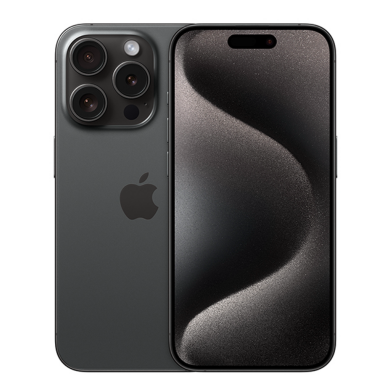

(600, 600, 3)

In [76]:
f = resize_foreground(cv2.imread("iphone_15.jpeg"), cv2.imread('3625454299.png'))
plt.axis('off')
plt.imshow(f)
plt.show()
f.shape

In [131]:
gray = cv2.cvtColor(foreground, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

# figure out to not crop the background, but resize the foreground (product image) to fit into the background
# if the width and height of the foreground is smaller than the background, should we crop?
crop_background = cv2.resize(background, (foreground.shape[1], foreground.shape[0]), interpolation = cv2.INTER_NEAREST)
_, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
mask = mask.astype(np.float64) / 255

result = (foreground * mask + crop_background * (1 - mask))
result = result.clip(0, 255).astype(np.uint8)

# crop_background.shape
result.shape

(600, 600, 3)

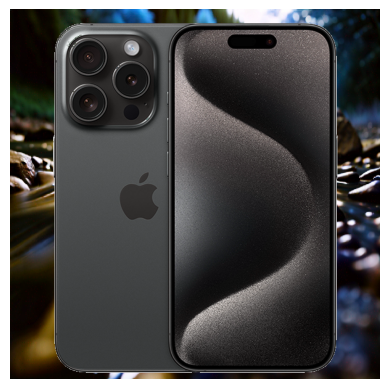

In [132]:
show_img(result)

In [166]:
def save_img(fname, img):
    cv2.imwrite(fname + '.jpeg', img)

In [169]:
fname = "a rose bloom in chaos.jpeg"


fname_fmt = lambda fname: "_".join(fname.split(" "))
fname_fmt(fname)

'a_rose_bloom_in_chaos.jpeg'

(896, 1152, 3)


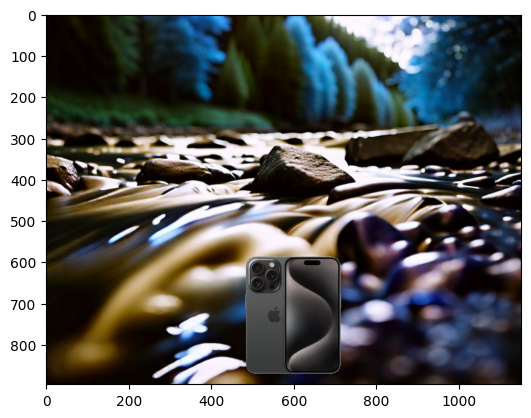

In [175]:
# https://datahacker.rs/012-blending-and-pasting-images-using-opencv/
# remove white bg

# get roi: region of interest, to which you want to put your image into
# ideally, foreground shape < background shape. If so, then resize foreground to be smaller

res = np.copy(background)

print(res.shape)

smaller_foreground = cv2.resize(foreground, (300, 300))

x_offset = res.shape[0] // 2
y_offset = res.shape[1] // 2

x_end = smaller_foreground.shape[0] + x_offset
y_end = smaller_foreground.shape[1] + y_offset

roi = res[y_offset:y_end,x_offset:x_end]

gray = cv2.cvtColor(smaller_foreground, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

_, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
mask = mask.astype(np.float64) / 255


result = (smaller_foreground * mask + roi * (1 - mask))
result = result.clip(0, 255).astype(np.uint8)

res[y_offset:y_end,x_offset:x_end] = result
show_img(res)
save_img('test_fg_bg', res)

In [195]:
def put_into_bg(bg, fg, x, y):
    assert x <= bg.shape[0], "x should not be larger than foreground width"
    assert y <= bg.shape[1], "y should not be larger than foreground height"
    res = np.copy(bg)
    smaller_foreground = cv2.resize(fg, (300, 300)) # let's force the foreground to be 300 x 300. If smaller, don't resize

    x_end = smaller_foreground.shape[0] + x
    y_end = smaller_foreground.shape[1] + y

    roi = res[y:y_end,x:x_end]

    gray = cv2.cvtColor(smaller_foreground, cv2.COLOR_BGR2GRAY)
    # gray = cv2.equalizeHist(gray)
    _, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

    _, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    mask = mask.astype(np.float64) / 255

    print("fg shape: ", smaller_foreground.shape)
    print("mask shape: ", mask.shape)
    print("roi shape: ", roi.shape)


    result = (smaller_foreground * mask + roi * (1 - mask))
    result = result.clip(0, 255).astype(np.uint8)

    res[y:y_end,x:x_end] = result

    return res

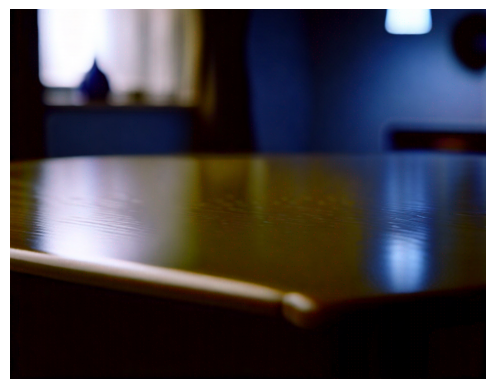

In [170]:
from stability_sdk import client
import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation
import warnings
import io
from PIL import Image

os.environ['STABILITY_HOST'] = 'grpc.stability.ai:443'
os.environ['STABILITY_KEY'] = 'sk-dLsfsiQPh2JbbeVFKHfbBSDb9H4q9DXFC7AHSb3jqdwS3siP'

stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'], # API Key reference.
    verbose=True, # Print debug messages.
    engine="stable-diffusion-xl-1024-v1-0", # Set the engine to use for generation.
    # Check out the following link for a list of available engines: https://platform.stability.ai/docs/features/api-parameters#engine
)

def generate_bg(prompt, style):
    answers = stability_api.generate(
		style_preset=style,
		adapter_strength=1.0,
    	prompt=prompt,
		steps=30,
		cfg_scale=35.0, 
		width=1152,
		height=896,
		sampler=generation.SAMPLER_K_DPMPP_2M 
	)
    for resp in answers:
        for artifact in resp.artifacts:
            if artifact.finish_reason == generation.FILTER:
                warnings.warn("Your request activated the API's safety filters and could not be processed. Please modify the prompt and try again.")
            if artifact.type == generation.ARTIFACT_IMAGE:
                global img
                img = Image.open(io.BytesIO(artifact.binary))
                return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
            
p = "surface of a smooth ceramic table"
s = "photographic"

test = generate_bg(p, s)
fname_fmt = lambda fname: "_".join(fname.split(" "))

show_img(test)
save_img(fname_fmt(p), test)

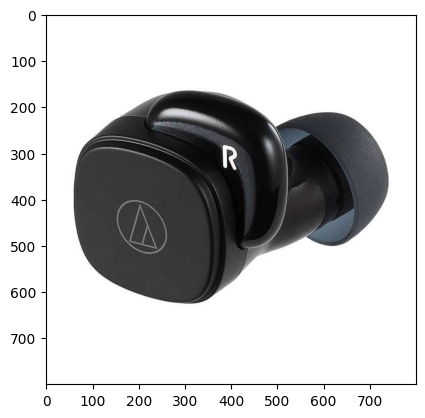

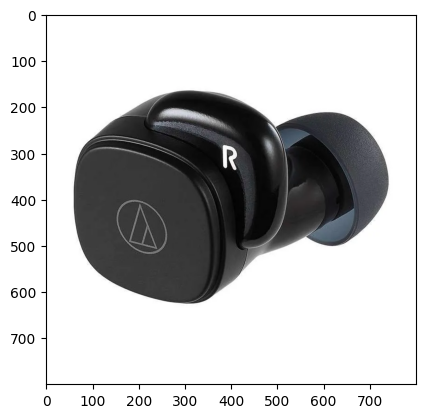

In [222]:
from PIL import ImageEnhance

def apply_color_temperature(src_image, target_image):
    # Convert source and target images to Lab color space
    src_lab = cv2.cvtColor(src_image, cv2.COLOR_BGR2LAB)
    target_lab = cv2.cvtColor(target_image, cv2.COLOR_BGR2LAB)

    # Split the Lab images into channels
    _, _, src_b = cv2.split(src_lab)
    l, a, b = cv2.split(target_lab)

    # Calculate the mean values of the 'b' channel for source and target images
    src_mean_b = np.mean(src_b)
    target_mean_b = np.mean(b)

    # Calculate the difference in 'b' channel means
    delta_b = src_mean_b - target_mean_b

    # Adjust the 'b' channel of the target image based on the difference
    adjusted_b = np.clip(b + delta_b, 0, 255).astype(np.uint8)

    # Merge the Lab channels back to form the adjusted image
    adjusted_lab = cv2.merge([l, a, adjusted_b])

    # Convert the adjusted Lab image back to BGR color space
    adjusted_image = cv2.cvtColor(adjusted_lab, cv2.COLOR_LAB2BGR)

    return adjusted_image

def apply_hue_and_saturation(source_img, target_img):
    # s_rgb = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
    # t_rgb = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    s_pil = Image.fromarray(source_img)
    t_pil = Image.fromarray(target_img)

    s_pil = s_pil.resize((800, 800))

    # Convert images to HSV color space (PIL doesn't support HSV directly)
    source_hsv = s_pil.convert('HSV')
    target_hsv = t_pil.convert('HSV')

    # Split the HSV images into channels
    source_h, source_s, source_v = source_hsv.split()
    target_h, target_s, target_v = target_hsv.split()

    print(source_h)
    print(source_s)
    print(target_v)

    # Replace the saturation channel in the target image with that from the source image
    result_hsv = Image.merge('HSV', (source_h, source_s, target_v))

    # Convert the result HSV image back to RGB color space
    result_rgb = result_hsv.convert('RGB')

    # Convert PIL image to NumPy array
    numpy_image = np.array(result_rgb)

    # Convert RGB to BGR (as OpenCV uses BGR format)
    # opencv_image = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)

    return numpy_image

bg_table = cv2.imread('surface_of_a_smooth_ceramic_table.jpeg')
fg_earbuds = cv2.imread('ath-earbuds-r.jpeg')
adjed_fg = apply_color_temperature(bg_table, fg_earbuds)

# h = 400
# w = 600
# (896, 1152, 3)

# show_img(apply_hue_and_saturation(bg_table, fg_earbuds))

show_img(adjed_fg)
show_img(fg_earbuds)